In [4]:
from citylearn import  CityLearn
import matplotlib.pyplot as plt
from pathlib import Path
from reward_function import reward_function
from agent import RL_Agents
import numpy as np

In [5]:
# Load environment
climate_zone = 1
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ["Building_1","Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9"]
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption']
env = CityLearn(data_path, building_attributes, weather_file, solar_profile, building_ids, buildings_states_actions = building_state_actions, cost_function = objective_function)

# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
# Can be obtained using observations_spaces[i].low or .high
observations_spaces, actions_spaces = env.get_state_action_spaces()

# Provides information on Building type, Climate Zone, Annual DHW demand, Annual Cooling Demand, Annual Electricity Demand, Solar Capacity, and correllations among buildings
building_info = env.get_building_information()

In [ ]:
# RL CONTROLLER
# Instantiating the control agent(s)
agents = RL_Agents(building_info, observations_spaces, actions_spaces)

# Select many episodes for training. In the final run we will set this value to 1 (the buildings run for one year)
episodes = 100

k, c = 0, 0
cost, cum_reward = {}, {}

# The number of episodes can be replaces by a stopping criterion (i.e. convergence of the average reward)
for e in range(episodes):     
    cum_reward[e] = 0
    rewards = []
    state = env.reset()
    done = False
    while not done:
        if k%(40000*4)==0:
            print('hour: '+str(k)+' of '+str(8760*episodes))
            
        action = agents.select_action(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward_function(reward) #See comments in reward_function.py
        agents.add_to_buffer(state, action, reward, next_state, done)
        state = next_state
        
        cum_reward[e] += reward[0]
        rewards.append(reward)
        k+=1
        
    cost[e] = env.cost()
    if c%20==0:
        print(cost[e])
    c+=1

In [ ]:
#Prints the cost of every episode. The lower the better. Costs lower than 1 are achieved by controllers that perform better than the RBC
cost

Text(0, 0.5, 'Actor loss')

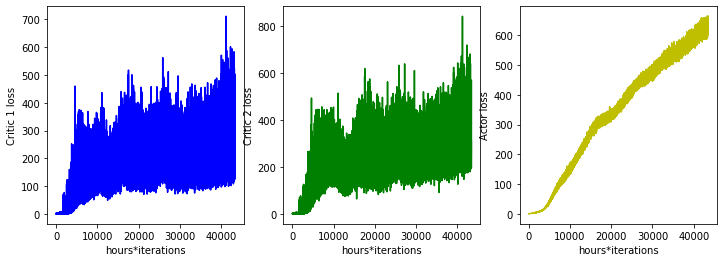

In [4]:
# Plots the actor and critic losses
fig, (plot1, plot2, plot3) = plt.subplots(1,3)
fig.set_size_inches(12,4)
plot1.plot(agents.critic1_loss_list[0],'b')
plot2.plot(agents.critic2_loss_list[0],'g')
plot3.plot(agents.actor_loss_list[0],'y')
plot1.set_xlabel('hours*iterations')
plot1.set_ylabel('Critic 1 loss')
plot2.set_xlabel('hours*iterations')
plot2.set_ylabel('Critic 2 loss')
plot3.set_xlabel('hours*iterations')
plot3.set_ylabel('Actor loss')